In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Using the prebuilt ToolNode

In [2]:
from langchain_core.tools import tool


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location == "san francisco":
        raise ValueError("Input queries must be proper nouns")
    elif location == "San Francisco":
        return "It's 60 degrees and foggy."
    else:
        raise ValueError("Invalid input.")

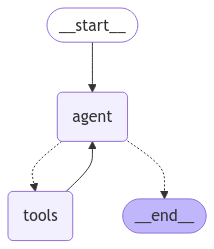

In [3]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([get_weather])

model_with_tools = model.bind_tools([get_weather])


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

app

In [4]:
response = app.invoke(
    {"messages": [("human", "what is the weather in san francisco?")]},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: what is the weather in san francisco?

AI: 

TOOL: It's 60 degrees and foggy.

AI: The weather in San Francisco is currently 60 degrees and foggy.



# Custom strategies

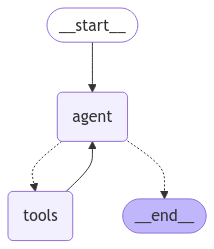

In [6]:
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field


class HaikuRequest(BaseModel):
    topic: list[str] = Field(
        max_length=3,
        min_length=3,
    )


@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


tool_node = ToolNode([master_haiku_generator])

model_with_tools = model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

app



In [7]:
response = app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: Write me an incredible haiku about water.

AI: 

TOOL: Gentle streams whisper,  
Nature's breath in liquid dance,  
Life flows, pure and free.

AI: Here’s an incredible haiku about water:

Gentle streams whisper,  
Nature's breath in liquid dance,  
Life flows, pure and free.



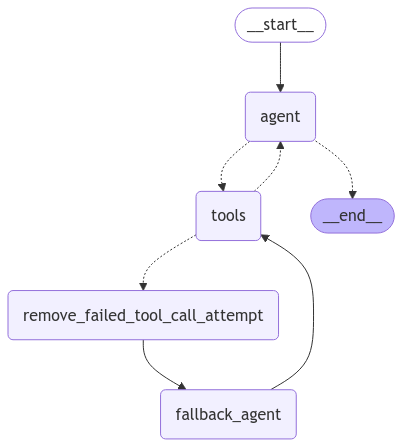

In [8]:
import json

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage


@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


def call_tool(state: MessagesState):
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # Return the error if the tool call fails
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": e},
                )
            )
    return {"messages": output_messages}


model_with_tools = model.bind_tools([master_haiku_generator])

better_model = model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    model='deepseek-chat',
                    openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    openai_api_base="https://api.deepseek.com/v1",
                    # model='gpt-4o-mini',
                    # openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    # openai_api_base="https://api.openai-proxy.org/v1",
                )
better_model_with_tools = better_model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

app

In [10]:
stream = app.stream(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: Py

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zVuXm3SyYHUaXPbD3ki9zgM5', 'function': {'arguments': '{"request":{"topic":["water","nature","flow"]}}', 'name': 'master_haiku_generator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 77, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3dac7959-d923-497b-820b-11123ca3e3cf-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water', 'nature', 'flow']}}, 'id': 'call_zVuXm3SyYHUaXPbD3ki9zgM5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 25, 'total_tokens':

Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: Py

{'fallback_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_e935cf10-a393-4ef9-9bb4-0ab2cfd8ec51', 'function': {'arguments': '{"request":{"topic":["water","nature","flow"]}}', 'name': 'master_haiku_generator'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 183, 'total_tokens': 213, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 183}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_f1afce2943', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-69b0057b-5959-4c1b-8969-8dfc4848b03d-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water', 'nature', 'flow']}}, 'id': 'call_0_e935cf10-a393-4ef9-9bb4-0ab2cfd8ec51', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 30, 'total_tokens': 213, 'input_token_details': {}, '

Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'NameError'>)
Failed to use model_dump to serialize <class 'langchain_core.messages.tool.ToolMessage'> to JSON: Py

{'fallback_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_4868fbe4-6831-4d6d-8a80-61e403569630', 'function': {'arguments': '{"request":{"topic":["water","nature","flow"]}}', 'name': 'master_haiku_generator'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 183, 'total_tokens': 213, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 55}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_f1afce2943', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-92c1554b-1540-45a8-82d4-a64665a6fa6a-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water', 'nature', 'flow']}}, 'id': 'call_0_4868fbe4-6831-4d6d-8a80-61e403569630', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 30, 'total_tokens': 213, 'input_token_details': {}, 

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT